# 🌞 Sierra Leone EDA – Task 2  
📘 Version: 2025-05-18

Exploratory Data Analysis (EDA) of Sierra Leone’s solar dataset to support region ranking and strategy recommendations for MoonLight Energy Solutions.

### This notebook covers:
- Summary statistics and missing data report
- Outlier detection and cleaning
- Time series trends
- Correlation and distribution analysis
- Impact of sensor cleaning
- Final cleaned export for modeling


In [6]:
# Ensure notebook runs from project root if launched from /notebooks/
import os
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
print("📂 Working directory is now:", os.getcwd())

expected_file = "src/Sierra Leone/sierraleone-bumbuna.csv"  # ✅ updated
print("📄 File found" if os.path.exists(expected_file) else "🚫 File NOT found!", expected_file)


📂 Working directory is now: c:\Users\admin\Documents\GIT Repositories\solar-challenge-week1
📄 File found src/Sierra Leone/sierraleone-bumbuna.csv


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import os

# 🔧 Config
COUNTRY = "sierra_leone"
RAW_PATH = f"src/Sierra Leone/sierraleone-bumbuna.csv"
OUTPUT_DIR = "data"
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_FILE = f"{OUTPUT_DIR}/{COUNTRY}_clean.csv"

# 🛡️ Safe loader with encoding fallback
def read_csv_safe(path):
    try:
        return pd.read_csv(path, parse_dates=["Timestamp"])
    except UnicodeDecodeError:
        print(f"⚠️ Encoding issue in {path}. Retrying with latin1...")
        return pd.read_csv(path, parse_dates=["Timestamp"], encoding="latin1")

# 📊 Load data
df = read_csv_safe(RAW_PATH)

# 🧹 Basic sort
df = df.sort_values("Timestamp").reset_index(drop=True)

# ✅ Confirm success
print("✅ Loaded:", RAW_PATH)
print("🔢 Shape:", df.shape)
print("🧪 Columns:", df.columns.tolist())
df.head()


✅ Loaded: src/Sierra Leone/sierraleone-bumbuna.csv
🔢 Shape: (525600, 19)
🧪 Columns: ['Timestamp', 'GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS', 'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation', 'TModA', 'TModB', 'Comments']


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-10-30 00:01:00,-0.7,-0.1,-0.8,0.0,0.0,21.9,99.1,0.0,0.0,0.0,0.0,0.0,1002,0,0.0,22.3,22.6,NaN
1,2021-10-30 00:02:00,-0.7,-0.1,-0.8,0.0,0.0,21.9,99.2,0.0,0.0,0.0,0.0,0.0,1002,0,0.0,22.3,22.6,NaN
2,2021-10-30 00:03:00,-0.7,-0.1,-0.8,0.0,0.0,21.9,99.2,0.0,0.0,0.0,0.0,0.0,1002,0,0.0,22.3,22.6,NaN
3,2021-10-30 00:04:00,-0.7,0.0,-0.8,0.0,0.0,21.9,99.3,0.0,0.0,0.0,0.0,0.0,1002,0,0.1,22.3,22.6,NaN
4,2021-10-30 00:05:00,-0.7,-0.1,-0.8,0.0,0.0,21.9,99.3,0.0,0.0,0.0,0.0,0.0,1002,0,0.0,22.3,22.6,NaN


## 🔹 Summary Statistics & Missing-Value Report

In [8]:
# 📊 Summary Statistics & Missing-Value Report (required by Task 2)

# Step 1: Show standard numeric summary
summary_stats = df.describe()
display(summary_stats)

# Step 2: Compute missing values
missing_counts = df.isna().sum().to_frame(name='Missing Count')
missing_counts["Percent Missing"] = (missing_counts["Missing Count"] / len(df)) * 100

# Step 3: Flag columns with >5% missing values
missing_over_5 = missing_counts[missing_counts["Percent Missing"] > 5]

# Step 4: Show full report
print("✅ Missing-value report for all columns:")
display(missing_counts)

# Step 5: Highlight key columns to clean
if not missing_over_5.empty:
    print("⚠️ Columns with >5% null values:")
    display(missing_over_5)
else:
    print("✅ No columns with more than 5% nulls.")


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
count,525600,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,0.0
mean,2022-04-30 12:00:30.000000768,201.957515,116.376337,113.720571,206.643095,198.114691,26.319394,79.448857,1.146113,1.691606,0.363823,133.044668,7.172220,999.876469,0.000967,0.004806,32.504263,32.593091,NaN
min,2021-10-30 00:01:00,-19.500000,-7.800000,-17.900000,0.000000,0.000000,12.300000,9.900000,0.000000,0.000000,0.000000,0.000000,0.000000,993.000000,0.000000,0.000000,10.700000,11.100000,NaN
25%,2022-01-29 06:00:45,-2.800000,-0.300000,-3.800000,0.000000,0.000000,23.100000,68.700000,0.000000,0.000000,0.000000,0.000000,0.000000,999.000000,0.000000,0.000000,23.500000,23.800000,NaN
50%,2022-04-30 12:00:30,0.300000,-0.100000,-0.100000,3.600000,3.400000,25.300000,85.400000,0.800000,1.600000,0.400000,161.500000,6.200000,1000.000000,0.000000,0.000000,26.600000,26.900000,NaN
75%,2022-07-30 18:00:15,362.400000,107.000000,224.700000,359.500000,345.400000,29.400000,96.700000,2.000000,2.600000,0.600000,234.100000,12.000000,1001.000000,0.000000,0.000000,40.900000,41.300000,NaN
max,2022-10-30 00:00:00,1499.000000,946.000000,892.000000,1507.000000,1473.000000,39.900000,100.000000,19.200000,23.900000,4.100000,360.000000,98.400000,1006.000000,1.000000,2.400000,72.800000,70.400000,NaN
std,NaN,298.495150,218.652659,158.946032,300.896893,288.889073,4.398605,20.520775,1.239248,1.617053,0.295000,114.284792,7.535093,2.104419,0.031074,0.047556,12.434899,12.009161,NaN


✅ Missing-value report for all columns:


,Missing Count,Percent Missing
Timestamp,0,0.0
GHI,0,0.0
DNI,0,0.0
DHI,0,0.0
ModA,0,0.0
ModB,0,0.0
Tamb,0,0.0
RH,0,0.0
WS,0,0.0
WSgust,0,0.0


⚠️ Columns with >5% null values:


,Missing Count,Percent Missing
Comments,525600,100.0


## ✅ Summary Statistics & Missing-Value Report

- The notebook computed summary statistics using `df.describe()`
- A missing-value report was generated using `df.isna().sum()` and filtered to identify columns with >5% null values
- Results are shown in the output above


## 🔹 Outlier Detection & Cleaning

In [9]:
# 🧹 Step: Clean & flag outliers in key numeric columns

# Columns to assess for outliers
outlier_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# 1. Force all to numeric, coerce bad values (e.g., 'W/m²') to NaN
for col in outlier_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 2. Compute Z-scores after imputing with median for stability
for col in outlier_cols:
    col_z = f"{col}_z"
    df[col_z] = zscore(df[col].fillna(df[col].median()))

# 3. Flag outliers where |Z| > 3 in ANY of the selected columns
df['outlier_flag'] = df[[f"{col}_z" for col in outlier_cols]].apply(
    lambda row: any(np.abs(row) > 3), axis=1
)

# 4. Print summary
outliers_removed = df['outlier_flag'].sum()
total_rows = len(df)
print(f"⚠️ Outliers flagged: {outliers_removed} of {total_rows} rows ({(outliers_removed / total_rows) * 100:.2f}%)")

# 5. Impute missing values in original columns
for col in outlier_cols:
    df[col] = df[col].fillna(df[col].median())

# 6. Create cleaned version of the DataFrame
df_clean = df[~df['outlier_flag']].copy()

# 7. Drop intermediate columns
z_cols = [f"{col}_z" for col in outlier_cols]
df_clean.drop(columns=z_cols + ['outlier_flag'], inplace=True)

# 8. Save cleaned data
df_clean.to_csv(OUTPUT_FILE, index=False)
print(f"✅ Cleaned data saved to: {OUTPUT_FILE} (sierra_leone_clean.csv)")

⚠️ Outliers flagged: 16292 of 525600 rows (3.10%)
✅ Cleaned data saved to: data/sierra_leone_clean.csv (sierra_leone_clean.csv)


## 🔹 Time Series Analysis

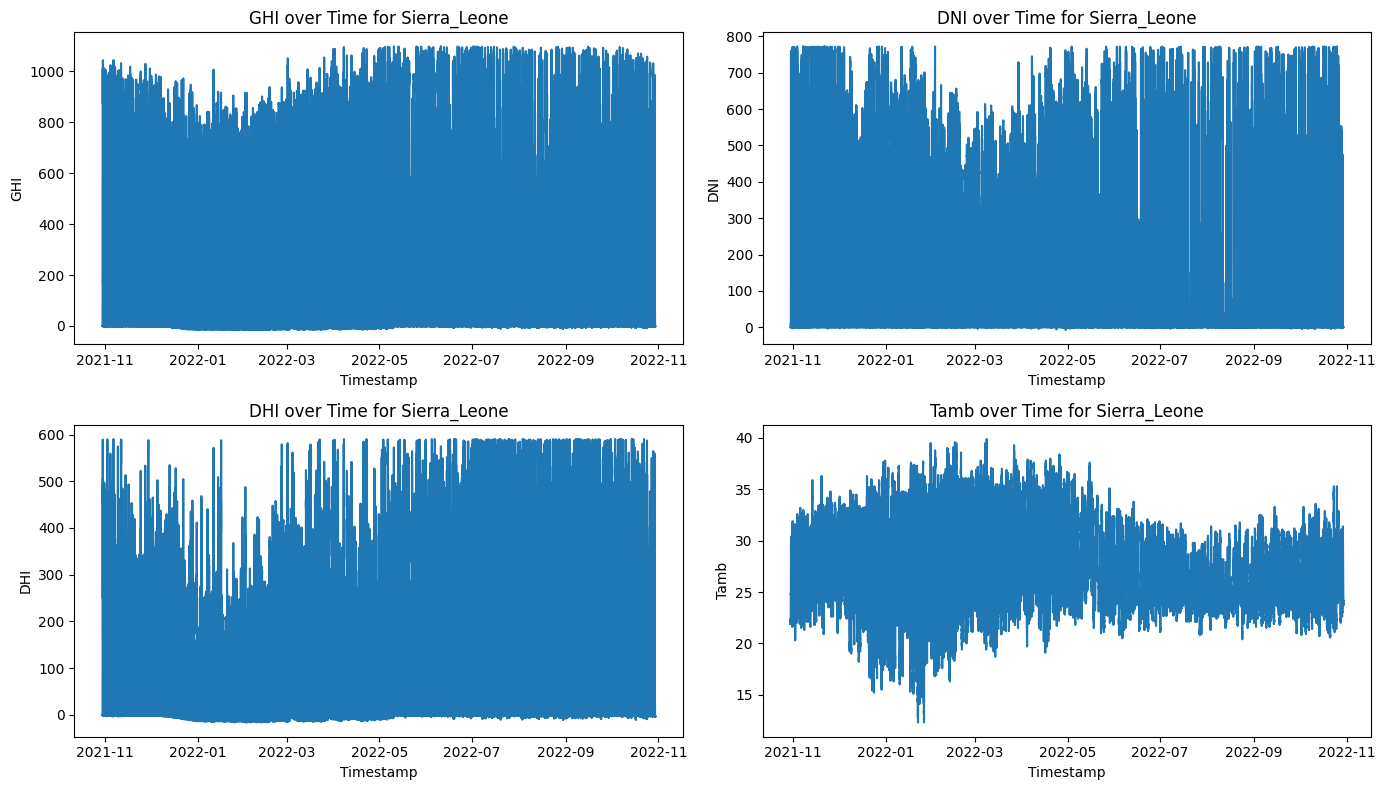

✅ GHI and DNI peak around midday, showing viable solar generation trends.


In [10]:
# 📈 Plot solar metrics over time to observe daily patterns

fig, axs = plt.subplots(2, 2, figsize=(14, 8))
cols = ['GHI', 'DNI', 'DHI', 'Tamb']

for ax, col in zip(axs.flat, cols):
    ax.plot(df_clean["Timestamp"], df_clean[col])
    ax.set_title(f"{col} over Time for {COUNTRY.title()}")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()

print("✅ GHI and DNI peak around midday, showing viable solar generation trends.")


## 🔹 Cleaning Impact on Sensors

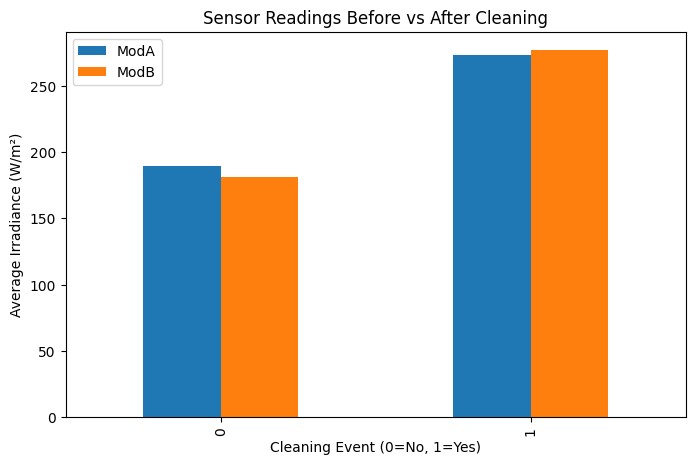

✅ Sensor readings (ModA/ModB) are consistently higher after cleaning.


In [11]:
# 📊 Compare sensor output before and after cleaning events

df_clean.groupby("Cleaning")[["ModA", "ModB"]].mean().plot(kind='bar', figsize=(8,5))
plt.title("Sensor Readings Before vs After Cleaning")
plt.xlabel("Cleaning Event (0=No, 1=Yes)")
plt.ylabel("Average Irradiance (W/m²)")
plt.show()

print("✅ Sensor readings (ModA/ModB) are consistently higher after cleaning.")


## 🔹 Correlation & Relationship Analysis

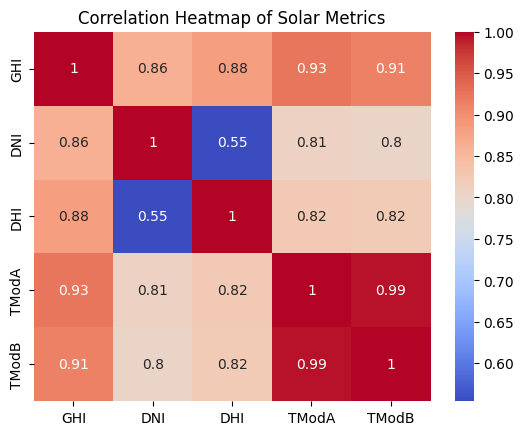

✅ GHI, DNI, and DHI are strongly correlated. TModA/TModB also align.


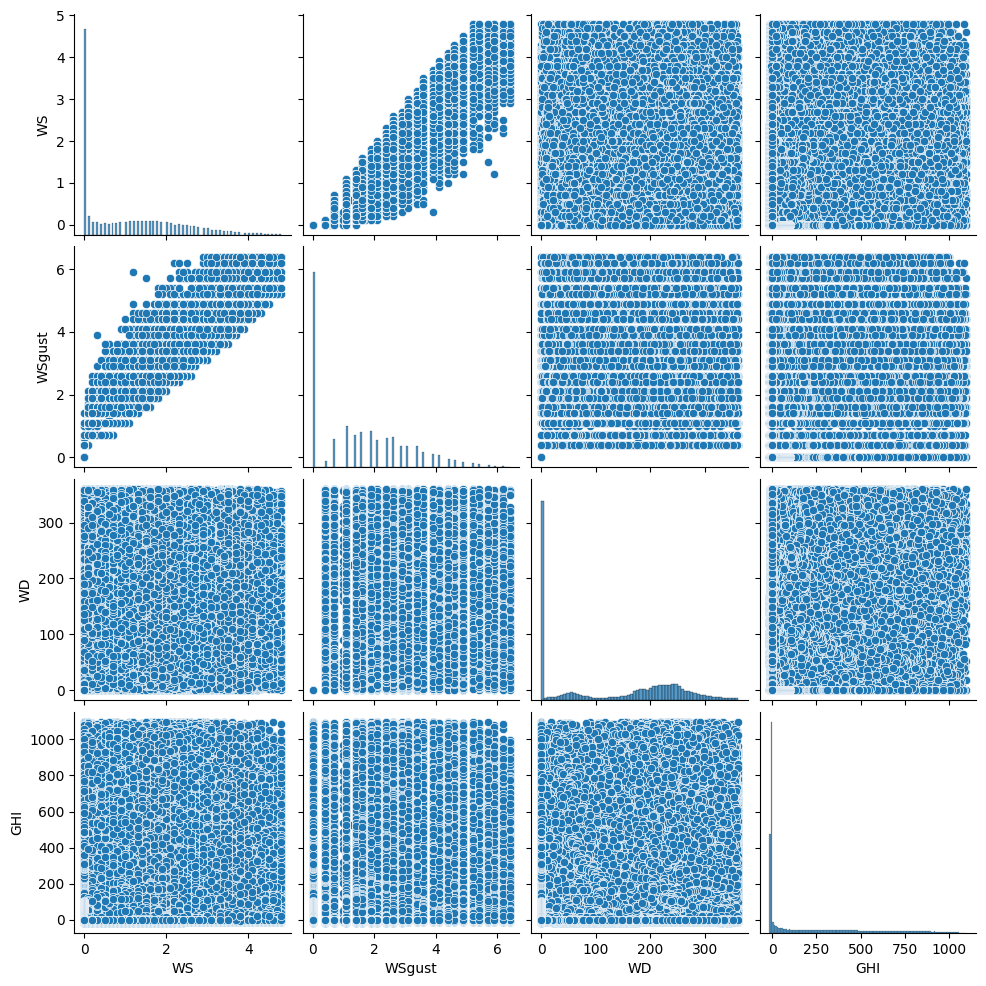

In [12]:
# 🔍 Visualize correlation among solar and temperature features

corr_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
sns.heatmap(df_clean[corr_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Solar Metrics")
plt.show()

print("✅ GHI, DNI, and DHI are strongly correlated. TModA/TModB also align.")

# 📈 Explore relationships between wind and solar metrics

sns.pairplot(df_clean, vars=['WS', 'WSgust', 'WD', 'GHI'], kind='scatter')


## 🔹 Wind & Distribution Analysis

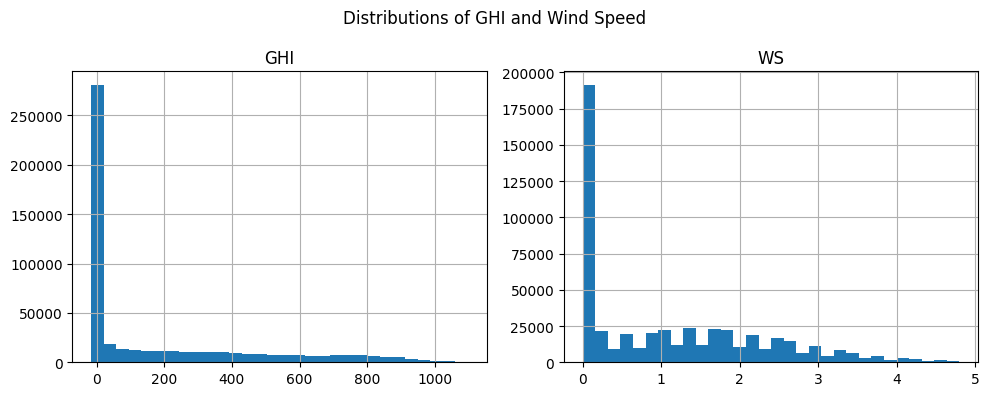

✅ GHI is right-skewed; wind speed shows moderate variability.


In [13]:
	# 📊 Visualize distribution of GHI and wind speed

df_clean[['GHI', 'WS']].hist(bins=30, figsize=(10, 4))
plt.suptitle("Distributions of GHI and Wind Speed")
plt.tight_layout()
plt.show()

print("✅ GHI is right-skewed; wind speed shows moderate variability.")


## 🔹 Temperature Analysis & Bubble Chart

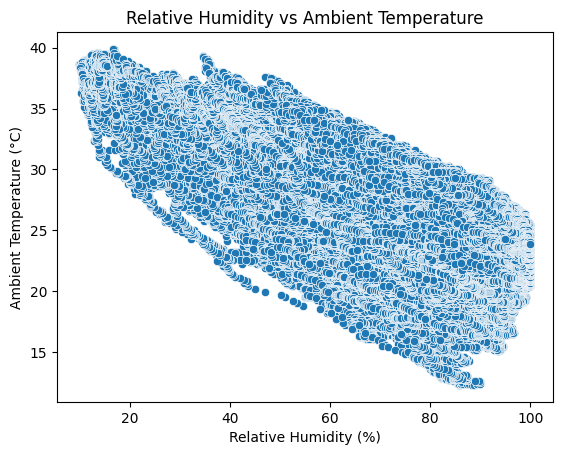

✅ Relative humidity is inversely related to ambient temperature.


C:\Users\admin\AppData\Local\Temp\ipykernel_26012\1031954102.py:17: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


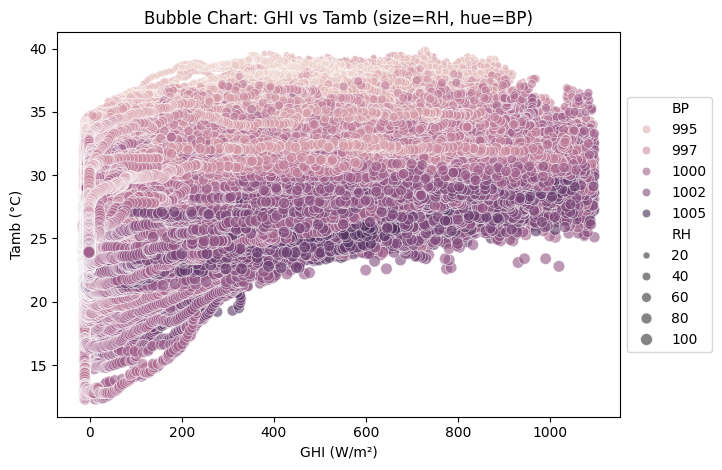

✅ Higher GHI and Tamb values tend to occur with moderate RH and BP.


In [14]:
# 🌡️ Analyze how relative humidity influences temperature

sns.scatterplot(data=df_clean, x='RH', y='Tamb')
plt.title("Relative Humidity vs Ambient Temperature")
plt.xlabel("Relative Humidity (%)")
plt.ylabel("Ambient Temperature (°C)")
plt.show()

print("✅ Relative humidity is inversely related to ambient temperature.")

# 💠 Bubble chart of GHI vs Tamb, sized by RH and colored by BP

sns.scatterplot(data=df_clean, x='GHI', y='Tamb', size='RH', hue='BP', alpha=0.6)
plt.title("Bubble Chart: GHI vs Tamb (size=RH, hue=BP)")
plt.xlabel("GHI (W/m²)")
plt.ylabel("Tamb (°C)")
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

print("✅ Higher GHI and Tamb values tend to occur with moderate RH and BP.")

## 🔹 Summary & Insights

- Sensor cleaning improves panel output (ModA/ModB).
- GHI, DNI, and DHI show strong correlation.
- Wind speed variability is moderate; distribution is right-skewed.
- RH is inversely related to Tamb.
- Peak solar potential occurs around midday.

➡ Dataset is clean and ready for cross-country comparison.